# ***Welcome to Offline Handwritten Text Recognition ***

#***Nvidia Gpu***

In [1]:
!nvidia-smi

Sat Jun  6 09:09:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#***Install tensorflow***

In [0]:
!pip install -q tensorflow-gpu==2.1.0

# ***Import Libraries***

In [0]:
import argparse
import h5py
import os
import datetime
import html
import xml.etree.ElementTree as ET
from functools import partial
from glob import glob
from multiprocessing import Pool
import re
import cv2
import html
import string
import numpy as np
import numba as nb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import h5py
import numpy as np
import unicodedata
import editdistance
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Conv2D, Multiply, Activation
import os
import numpy as np
import tensorflow as tf
from itertools import groupby
from contextlib import redirect_stdout
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Conv2D, Bidirectional, LSTM, GRU, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, PReLU
from tensorflow.keras.layers import Input, Add, Activation, Lambda, MaxPooling2D, Reshape
import datetime
import pandas as pd 
import math
from scipy.signal import argrelmin


#***Connect To Google Drive***

In [3]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# ***Image Preprocessing techniques***

In [0]:
def adjust_to_see(img):
    """Rotate and transpose to image visualize (cv2 method or jupyter notebook)"""

    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), -90, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    img = cv2.warpAffine(img, M, (nW + 1, nH + 1))
    img = cv2.warpAffine(img.transpose(), M, (nW, nH))

    return img


def augmentation(imgs,
                 rotation_range=0,
                 scale_range=0,
                 height_shift_range=0,
                 width_shift_range=0,
                 dilate_range=1,
                 erode_range=1):
    """Apply variations to a list of images (rotate, width and height shift, scale, erode, dilate)"""

    imgs = imgs.astype(np.float32)
    _, h, w = imgs.shape

    dilate_kernel = np.ones((int(np.random.uniform(1, dilate_range)),), np.uint8)
    erode_kernel = np.ones((int(np.random.uniform(1, erode_range)),), np.uint8)
    height_shift = np.random.uniform(-height_shift_range, height_shift_range)
    rotation = np.random.uniform(-rotation_range, rotation_range)
    scale = np.random.uniform(1 - scale_range, 1)
    width_shift = np.random.uniform(-width_shift_range, width_shift_range)

    trans_map = np.float32([[1, 0, width_shift * w], [0, 1, height_shift * h]])
    rot_map = cv2.getRotationMatrix2D((w // 2, h // 2), rotation, scale)

    trans_map_aff = np.r_[trans_map, [[0, 0, 1]]]
    rot_map_aff = np.r_[rot_map, [[0, 0, 1]]]
    affine_mat = rot_map_aff.dot(trans_map_aff)[:2, :]

    for i in range(len(imgs)):
        imgs[i] = cv2.warpAffine(imgs[i], affine_mat, (w, h), flags=cv2.INTER_NEAREST, borderValue=255)
        imgs[i] = cv2.erode(imgs[i], erode_kernel, iterations=1)
        imgs[i] = cv2.dilate(imgs[i], dilate_kernel, iterations=1)

    return imgs


def normalization(imgs):
    """Normalize list of images"""

    imgs = np.asarray(imgs).astype(np.float32)
    _, h, w = imgs.shape

    for i in range(len(imgs)):
        m, s = cv2.meanStdDev(imgs[i])
        imgs[i] = imgs[i] - m[0][0]
        imgs[i] = imgs[i] / s[0][0] if s[0][0] > 0 else imgs[i]

    return np.expand_dims(imgs, axis=-1)


"""
Preprocess metodology based in:
    H. Scheidl, S. Fiel and R. Sablatnig,
    Word Beam Search: A Connectionist Temporal Classification Decoding Algorithm, in
    16th International Conference on Frontiers in Handwriting Recognition, pp. 256-258, 2018.
"""


def preprocess(img, input_size):
    """Make the process with the `input_size` to the scale resize"""

    if isinstance(img, str):
        img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

    if isinstance(img, tuple):
        image, boundbox = img
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

        for i in range(len(boundbox)):
            if isinstance(boundbox[i], float):
                total = len(img) if i < 2 else len(img[0])
                boundbox[i] = int(total * boundbox[i])

        img = np.asarray(img[boundbox[0]:boundbox[1], boundbox[2]:boundbox[3]], dtype=np.uint8)

    wt, ht, _ = input_size
    h, w = np.asarray(img).shape
    f = max((w / wt), (h / ht))

    new_size = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1))
    img = cv2.resize(img, new_size)

    _, binary = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)

    if np.sum(img) * 0.8 > np.sum(binary):
        img = illumination_compensation(img)

    img = remove_cursive_style(img)

    target = np.ones([ht, wt], dtype=np.uint8) * 255
    target[0:new_size[1], 0:new_size[0]] = img
    img = cv2.transpose(target)

    return img


"""
Illumination Compensation based in:
    K.-N. Chen, C.-H. Chen, C.-C. Chang,
    Efficient illumination compensation techniques for text images, in
    Digital Signal Processing, 22(5), pp. 726-733, 2012.
"""


def illumination_compensation(img, only_cei=False):
    """Illumination compensation technique for text image"""

    _, binary = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY)

    if np.sum(binary) > np.sum(img) * 0.8:
        return np.asarray(img, dtype=np.uint8)

    def scale(img):
        s = np.max(img) - np.min(img)
        res = img / s
        res -= np.min(res)
        res *= 255
        return res

    img = img.astype(np.float32)
    height, width = img.shape
    sqrt_hw = np.sqrt(height * width)

    bins = np.arange(0, 300, 10)
    bins[26] = 255
    hp = np.histogram(img, bins)

    for i in range(len(hp[0])):
        if hp[0][i] > sqrt_hw:
            hr = i * 10
            break

    np.seterr(divide='ignore', invalid='ignore')
    cei = (img - (hr + 50 * 0.3)) * 2
    cei[cei > 255] = 255
    cei[cei < 0] = 0

    if only_cei:
        return np.asarray(cei, dtype=np.uint8)

    m1 = np.asarray([-1, 0, 1, -2, 0, 2, -1, 0, 1]).reshape((3, 3))
    m2 = np.asarray([-2, -1, 0, -1, 0, 1, 0, 1, 2]).reshape((3, 3))
    m3 = np.asarray([-1, -2, -1, 0, 0, 0, 1, 2, 1]).reshape((3, 3))
    m4 = np.asarray([0, 1, 2, -1, 0, 1, -2, -1, 0]).reshape((3, 3))

    eg1 = np.abs(cv2.filter2D(img, -1, m1))
    eg2 = np.abs(cv2.filter2D(img, -1, m2))
    eg3 = np.abs(cv2.filter2D(img, -1, m3))
    eg4 = np.abs(cv2.filter2D(img, -1, m4))

    eg_avg = scale((eg1 + eg2 + eg3 + eg4) / 4)

    h, w = eg_avg.shape
    eg_bin = np.zeros((h, w))
    eg_bin[eg_avg >= 30] = 255

    h, w = cei.shape
    cei_bin = np.zeros((h, w))
    cei_bin[cei >= 60] = 255

    h, w = eg_bin.shape
    tli = 255 * np.ones((h, w))
    tli[eg_bin == 255] = 0
    tli[cei_bin == 255] = 0

    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(tli, kernel, iterations=1)
    int_img = np.asarray(cei)

    estimate_light_distribution(width, height, erosion, cei, int_img)

    mean_filter = 1 / 121 * np.ones((11, 11), np.uint8)
    ldi = cv2.filter2D(scale(int_img), -1, mean_filter)

    result = np.divide(cei, ldi) * 260
    result[erosion != 0] *= 1.5
    result[result < 0] = 0
    result[result > 255] = 255

    return np.asarray(result, dtype=np.uint8)


@nb.jit(nopython=True)
def estimate_light_distribution(width, height, erosion, cei, int_img):
    """Light distribution performed by numba (thanks @Sundrops)"""

    for y in range(width):
        for x in range(height):
            if erosion[x][y] == 0:
                i = x

                while i < erosion.shape[0] and erosion[i][y] == 0:
                    i += 1

                end = i - 1
                n = end - x + 1

                if n <= 30:
                    h, e = [], []

                    for k in range(5):
                        if x - k >= 0:
                            h.append(cei[x - k][y])

                        if end + k < cei.shape[0]:
                            e.append(cei[end + k][y])

                    mpv_h, mpv_e = max(h), max(e)

                    for m in range(n):
                        int_img[x + m][y] = mpv_h + (m + 1) * ((mpv_e - mpv_h) / n)

                x = end
                break


"""
Deslating image process based in,
    A. Vinciarelli and J. Luettin,
    A New Normalization Technique for Cursive Handwritten Wrods, in
    Pattern Recognition, 22, 2001.
"""


def remove_cursive_style(img):
    """Remove cursive writing style from image with deslanting algorithm"""

    def calc_y_alpha(vec):
        indices = np.where(vec > 0)[0]
        h_alpha = len(indices)

        if h_alpha > 0:
            delta_y_alpha = indices[h_alpha - 1] - indices[0] + 1

            if h_alpha == delta_y_alpha:
                return h_alpha * h_alpha
        return 0

    alpha_vals = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
    rows, cols = img.shape
    results = []

    ret, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary = otsu if ret < 127 else sauvola(img, (int(img.shape[0] / 2), int(img.shape[0] / 2)), 127, 1e-2)

    for alpha in alpha_vals:
        shift_x = max(-alpha * rows, 0.)
        size = (cols + int(np.ceil(abs(alpha * rows))), rows)
        transform = np.asarray([[1, alpha, shift_x], [0, 1, 0]], dtype=np.float)

        shear_img = cv2.warpAffine(binary, transform, size, cv2.INTER_NEAREST)
        sum_alpha = 0
        sum_alpha += np.apply_along_axis(calc_y_alpha, 0, shear_img)
        results.append([np.sum(sum_alpha), size, transform])

    result = sorted(results, key=lambda x: x[0], reverse=True)[0]
    result = cv2.warpAffine(img, result[2], result[1], borderValue=255)
    result = cv2.resize(result, dsize=(cols, rows))

    return np.asarray(result, dtype=np.uint8)


"""
Sauvola binarization based in,
    J. Sauvola, T. Seppanen, S. Haapakoski, M. Pietikainen,
    Adaptive Document Binarization, in IEEE Computer Society Washington, 1997.
"""


def sauvola(img, window, thresh, k):
    """Sauvola binarization"""

    rows, cols = img.shape
    pad = int(np.floor(window[0] / 2))
    sum2, sqsum = cv2.integral2(
        cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT))

    isum = sum2[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sum2[0:rows, 0:cols] - \
        sum2[window[0]:rows + window[0], 0:cols] - \
        sum2[0:rows, window[1]:cols + window[1]]

    isqsum = sqsum[window[0]:rows + window[0], window[1]:cols + window[1]] + \
        sqsum[0:rows, 0:cols] - \
        sqsum[window[0]:rows + window[0], 0:cols] - \
        sqsum[0:rows, window[1]:cols + window[1]]

    ksize = window[0] * window[1]
    mean = isum / ksize
    std = (((isqsum / ksize) - (mean**2) / ksize) / ksize) ** 0.5
    threshold = (mean * (1 + k * (std / thresh - 1))) * (mean >= 100)

    return np.asarray(255 * (img >= threshold), 'uint8')


"""
DeepSpell based text cleaning process.
    Tal Weiss.
    Deep Spelling.
    Medium: https://machinelearnings.co/deep-spelling-9ffef96a24f6#.2c9pu8nlm
    Github: https://github.com/MajorTal/DeepSpell
"""

RE_DASH_FILTER = re.compile(r'[\-\˗\֊\‐\‑\‒\–\—\⁻\₋\−\﹣\－]', re.UNICODE)
RE_APOSTROPHE_FILTER = re.compile(r'&#39;|[ʼ՚＇‘’‛❛❜ߴߵ`‵´ˊˋ{}{}{}{}{}{}{}{}{}]'.format(
    chr(768), chr(769), chr(832), chr(833), chr(2387),
    chr(5151), chr(5152), chr(65344), chr(8242)), re.UNICODE)
RE_RESERVED_CHAR_FILTER = re.compile(r'[¶¤«»]', re.UNICODE)
RE_LEFT_PARENTH_FILTER = re.compile(r'[\(\[\{\⁽\₍\❨\❪\﹙\（]', re.UNICODE)
RE_RIGHT_PARENTH_FILTER = re.compile(r'[\)\]\}\⁾\₎\❩\❫\﹚\）]', re.UNICODE)
RE_BASIC_CLEANER = re.compile(r'[^\w\s{}]'.format(re.escape(string.punctuation)), re.UNICODE)

LEFT_PUNCTUATION_FILTER = """!%&),.:;<=>?@\\]^_`|}~"""
RIGHT_PUNCTUATION_FILTER = """"(/<=>@[\\^_`{|~"""
NORMALIZE_WHITESPACE_REGEX = re.compile(r'[^\S\n]+', re.UNICODE)


def text_standardize(text):
    """Organize/add spaces around punctuation marks"""

    if text is None:
        return ""

    text = html.unescape(text).replace("\\n", "").replace("\\t", "")

    text = RE_RESERVED_CHAR_FILTER.sub("", text)
    text = RE_DASH_FILTER.sub("-", text)
    text = RE_APOSTROPHE_FILTER.sub("'", text)
    text = RE_LEFT_PARENTH_FILTER.sub("(", text)
    text = RE_RIGHT_PARENTH_FILTER.sub(")", text)
    text = RE_BASIC_CLEANER.sub("", text)

    text = text.lstrip(LEFT_PUNCTUATION_FILTER)
    text = text.rstrip(RIGHT_PUNCTUATION_FILTER)
    text = text.translate(str.maketrans({c: f" {c} " for c in string.punctuation}))
    text = NORMALIZE_WHITESPACE_REGEX.sub(" ", text.strip())

    return text




#***Data generator realted logic***

In [0]:
class DataGenerator():
    """Generator class with data streaming"""

    def __init__(self, source, batch_size, charset, max_text_length, predict=False):
        self.tokenizer = Tokenizer(charset, max_text_length)
        self.batch_size = batch_size
        self.partitions = ['test'] if predict else ['train', 'valid', 'test']

        self.size = dict()
        self.steps = dict()
        self.index = dict()
        self.dataset = dict()

        with h5py.File(source, "r") as f:
            for pt in self.partitions:
                self.dataset[pt] = dict()

                self.dataset[pt]['dt'] = np.array(f[pt]['dt'])
                self.dataset[pt]['gt'] = np.array(f[pt]['gt'])

                randomize = np.arange(len(self.dataset[pt]['gt']))
                np.random.seed(42)
                np.random.shuffle(randomize)

                self.dataset[pt]['dt'] = self.dataset[pt]['dt'][randomize]
                self.dataset[pt]['gt'] = self.dataset[pt]['gt'][randomize]

        for pt in self.partitions:
            # decode sentences from byte
            self.dataset[pt]['gt'] = [x.decode() for x in self.dataset[pt]['gt']]

            # set size and setps
            self.size[pt] = len(self.dataset[pt]['gt'])
            self.steps[pt] = int(np.ceil(self.size[pt] / self.batch_size))
            self.index[pt] = 0

    def next_train_batch(self):
        """Get the next batch from train partition (yield)"""

        while True:
            if self.index['train'] >= self.size['train']:
                self.index['train'] = 0

            index = self.index['train']
            until = self.index['train'] + self.batch_size
            self.index['train'] = until

            x_train = self.dataset['train']['dt'][index:until]
            x_train = augmentation(x_train,
                                      rotation_range=1.5,
                                      scale_range=0.05,
                                      height_shift_range=0.025,
                                      width_shift_range=0.05,
                                      erode_range=5,
                                      dilate_range=3)
            x_train = normalization(x_train)

            y_train = [self.tokenizer.encode(y) for y in self.dataset['train']['gt'][index:until]]
            y_train = [np.pad(y, (0, self.tokenizer.maxlen - len(y))) for y in y_train]
            y_train = np.asarray(y_train, dtype=np.int16)

            yield (x_train, y_train)

    def next_valid_batch(self):
        """Get the next batch from validation partition (yield)"""

        while True:
            if self.index['valid'] >= self.size['valid']:
                self.index['valid'] = 0

            index = self.index['valid']
            until = self.index['valid'] + self.batch_size
            self.index['valid'] = until

            x_valid = self.dataset['valid']['dt'][index:until]
            x_valid = normalization(x_valid)

            y_valid = [self.tokenizer.encode(y) for y in self.dataset['valid']['gt'][index:until]]
            y_valid = [np.pad(y, (0, self.tokenizer.maxlen - len(y))) for y in y_valid]
            y_valid = np.asarray(y_valid, dtype=np.int16)

            yield (x_valid, y_valid)

    def next_test_batch(self):
        """Return model predict parameters"""

        while True:
            if self.index['test'] >= self.size['test']:
                self.index['test'] = 0
                break

            index = self.index['test']
            until = self.index['test'] + self.batch_size
            self.index['test'] = until

            x_test = self.dataset['test']['dt'][index:until]
            x_test = normalization(x_test)

            yield x_test


class Tokenizer():
    """Manager tokens functions and charset/dictionary properties"""

    def __init__(self, chars, max_text_length=128):
        self.PAD_TK, self.UNK_TK = "¶", "¤"
        self.chars = (self.PAD_TK + self.UNK_TK + chars)

        self.PAD = self.chars.find(self.PAD_TK)
        self.UNK = self.chars.find(self.UNK_TK)

        self.vocab_size = len(self.chars)
        self.maxlen = max_text_length

    def encode(self, text):
        """Encode text to vector"""

        text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("ASCII")
        text = " ".join(text.split())

        groups = ["".join(group) for _, group in groupby(text)]
        text = "".join([self.UNK_TK.join(list(x)) if len(x) > 1 else x for x in groups])
        encoded = []

        for item in text:
            index = self.chars.find(item)
            index = self.UNK if index == -1 else index
            encoded.append(index)

        return np.asarray(encoded)

    def decode(self, text):
        """Decode vector to text"""

        decoded = "".join([self.chars[int(x)] for x in text if x > -1])
        decoded = self.remove_tokens(decoded)
        decoded = text_standardize(decoded)

        return decoded

    def remove_tokens(self, text):
        """Remove tokens (PAD) from text"""

        return text.replace(self.PAD_TK, "").replace(self.UNK_TK, "")

#***Evaluation Metrics CER, WER , SER Calculation Logic***

In [0]:
def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):
        pd, gt = pd.lower(), gt.lower()

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd), list(gt)
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.split(), gt.split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    metrics = [cer, wer, ser]
    metrics = np.mean(metrics, axis=1)

    return metrics

#***Functions to read IAM dataset***

In [0]:
"""Dataset reader and process"""

class Dataset():
    """Dataset class to read images and sentences from base (raw files)"""

    def __init__(self, source, name):
        self.source = source
        self.name = name
        self.dataset = None
        self.partitions = ['train', 'valid', 'test']

    def read_partitions(self):
        """Read images and sentences from dataset"""

        self.dataset = getattr(self, f"_{self.name}")()

    def preprocess_partitions(self, input_size):
        """Preprocess images and sentences from partitions"""

        for y in self.partitions:
            arange = range(len(self.dataset[y]['gt']))

            for i in reversed(arange):
                text = text_standardize(self.dataset[y]['gt'][i])

                if not self.check_text(text):
                    self.dataset[y]['gt'].pop(i)
                    self.dataset[y]['dt'].pop(i)
                    continue

                self.dataset[y]['gt'][i] = text.encode()

            pool = Pool()
            self.dataset[y]['dt'] = pool.map(partial(preprocess, input_size=input_size), self.dataset[y]['dt'])
            pool.close()
            pool.join()

    def _iam(self):
        """IAM dataset reader"""

        pt_path = os.path.join(self.source, "largeWriterIndependentTextLineRecognitionTask")
        paths = {"train": open(os.path.join(pt_path, "trainset.txt")).read().splitlines(),
                 "valid": open(os.path.join(pt_path, "validationset1.txt")).read().splitlines(),
                 "test": open(os.path.join(pt_path, "testset.txt")).read().splitlines()}

        lines = open(os.path.join(self.source, "ascii", "lines.txt")).read().splitlines()
        gt_dict = dict()

        for line in lines:
            if (not line or line[0] == "#"):
                continue

            split = line.split()

            if split[1] == "ok":
                gt_dict[split[0]] = " ".join(split[8::]).replace("|", " ")

        dataset = dict()

        for i in self.partitions:
            dataset[i] = {"dt": [], "gt": []}

            for line in paths[i]:
                try:
                    split = line.split("-")
                    folder = f"{split[0]}-{split[1]}"

                    img_file = f"{split[0]}-{split[1]}-{split[2]}.png"
                    img_path = os.path.join(self.source, "lines", split[0], folder, img_file)

                    dataset[i]['gt'].append(gt_dict[line])
                    dataset[i]['dt'].append(img_path)
                except KeyError:
                    pass

        return dataset


    @staticmethod
    def check_text(text):
        """Make sure text has more characters instead of punctuation marks"""

        strip_punc = text.strip(string.punctuation).strip()
        no_punc = text.translate(str.maketrans("", "", string.punctuation)).strip()

        if len(text) == 0 or len(strip_punc) == 0 or len(no_punc) == 0:
            return False

        punc_percent = (len(strip_punc) - len(no_punc)) / len(strip_punc)

        return len(no_punc) >= 2 and punc_percent <= 0.1

#***Custom Convolution Layers***

In [0]:

"""
Gated implementations
    GatedConv2D: Introduce a Conv2D layer (same number of filters) to multiply with its sigmoid activation.
    FullGatedConv2D: Introduce a Conv2D to extract features (linear and sigmoid), making a full gated process.
                     This process will double number of filters to make one convolutional process.
"""



"""
Tensorflow Keras layer implementation of the gated convolution.
    Args:
        kwargs: Conv2D keyword arguments.
    Reference:
        T. Bluche, R. Messina,
        Gated convolutional recurrent neural networks for multilingual handwriting recognition.
        14th IAPR International Conference on Document Analysis andRecognition (ICDAR),
        p. 646–651, 11 2017.
"""


class GatedConv2D(Conv2D):
    """Gated Convolutional Class"""

    def __init__(self, **kwargs):
        super(GatedConv2D, self).__init__(**kwargs)

    def call(self, inputs):
        """Apply gated convolution"""

        output = super(GatedConv2D, self).call(inputs)
        linear = Activation("linear")(inputs)
        sigmoid = Activation("sigmoid")(output)

        return Multiply()([linear, sigmoid])

    def get_config(self):
        """Return the config of the layer"""

        config = super(GatedConv2D, self).get_config()
        return config


"""
Tensorflow Keras layer implementation of the gated convolution.
    Args:
        filters (int): Number of output filters.
        kwargs: Other Conv2D keyword arguments.
    Reference (based):
        Y. N. Dauphin, A. Fan, M. Auli, and D. Grangier,
        Language modeling with gated convolutional networks, in
        Proc. 34th Int. Conf. Mach. Learn. (ICML), vol. 70,
        Sydney, Australia, pp. 933–941, 2017.
        A. van den Oord and N. Kalchbrenner and O. Vinyals and L. Espeholt and A. Graves and K. Kavukcuoglu
        Conditional Image Generation with PixelCNN Decoders, 2016
        NIPS'16 Proceedings of the 30th International Conference on Neural Information Processing Systems
"""


class FullGatedConv2D(Conv2D):
    """Gated Convolutional Class"""

    def __init__(self, filters, **kwargs):
        super(FullGatedConv2D, self).__init__(filters=filters * 2, **kwargs)
        self.nb_filters = filters

    def call(self, inputs):
        """Apply gated convolution"""

        output = super(FullGatedConv2D, self).call(inputs)
        linear = Activation("linear")(output[:, :, :, :self.nb_filters])
        sigmoid = Activation("sigmoid")(output[:, :, :, self.nb_filters:])

        return Multiply()([linear, sigmoid])

    def compute_output_shape(self, input_shape):
        """Compute shape of layer output"""

        output_shape = super(FullGatedConv2D, self).compute_output_shape(input_shape)
        return tuple(output_shape[:3]) + (self.nb_filters,)

    def get_config(self):
        """Return the config of the layer"""

        config = super(FullGatedConv2D, self).get_config()
        config['nb_filters'] = self.nb_filters
        del config['filters']
        return config


#***Define model Layers and related functions***

In [0]:
"""Handwritten Text Recognition Neural Network"""

"""
HTRModel Class based on:
    Y. Soullard, C. Ruffino and T. Paquet,
    CTCModel: A Connectionnist Temporal Classification implementation for Keras.
    ee: https://arxiv.org/abs/1901.07957, 2019.
    github: https://github.com/ysoullard/HTRModel
The HTRModel class use Tensorflow 2 Keras module for the use of the
Connectionist Temporal Classification (CTC) with the Hadwritten Text Recognition (HTR).
In a Tensorflow Keras Model, x is the input features and y the labels.
"""

class HTRModel:

    def __init__(self,
                 architecture,
                 input_size,
                 vocab_size,
                 greedy=True,
                 beam_width=10,
                 top_paths=1):
        """
        Initialization of a HTR Model.
        :param
            architecture: option of the architecture model to build and compile
            greedy, beam_width, top_paths: Parameters of the CTC decoding
            (see ctc decoding tensorflow for more details)
        """

        self.architecture = globals()[architecture]
        self.input_size = input_size
        self.vocab_size = vocab_size

        self.model = None
        self.greedy = greedy
        self.beam_width = beam_width
        self.top_paths = max(1, top_paths)

    def summary(self, output=None, target=None):
        """Show/Save model structure (summary)"""

        self.model.summary()

        if target is not None:
            os.makedirs(output, exist_ok=True)

            with open(os.path.join(output, target), "w") as f:
                with redirect_stdout(f):
                    self.model.summary()

    def load_checkpoint(self, target):
        """ Load a model with checkpoint file"""

        if os.path.isfile(target):
            if self.model is None:
                self.compile()

            self.model.load_weights(target)

    def get_callbacks(self, logdir, checkpoint, monitor="val_loss", verbose=0):
        """Setup the list of callbacks for the model"""

        callbacks = [
            CSVLogger(
                filename=os.path.join(logdir, "epochs.log"),
                separator=";",
                append=True),
            TensorBoard(
                log_dir=logdir,
                histogram_freq=10,
                profile_batch=0,
                write_graph=True,
                write_images=False,
                update_freq="epoch"),
            ModelCheckpoint(
                filepath=checkpoint,
                monitor=monitor,
                save_best_only=True,
                save_weights_only=True,
                verbose=verbose),
            EarlyStopping(
                monitor=monitor,
                min_delta=1e-8,
                patience=20,
                restore_best_weights=True,
                verbose=verbose),
            ReduceLROnPlateau(
                monitor=monitor,
                min_delta=1e-8,
                factor=0.2,
                patience=15,
                verbose=verbose)
        ]

        return callbacks

    def compile(self, learning_rate=None):
        """
        Configures the HTR Model for training/predict.
        :param optimizer: optimizer for training
        """

        # define inputs, outputs and optimizer of the chosen architecture
        outs = self.architecture(self.input_size, self.vocab_size + 1, learning_rate)
        inputs, outputs, optimizer = outs

        # create and compile
        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=optimizer, loss=self.ctc_loss_lambda_func)

    def fit(self,
            x=None,
            y=None,
            batch_size=None,
            epochs=1,
            verbose=1,
            callbacks=None,
            validation_split=0.0,
            validation_data=None,
            shuffle=True,
            class_weight=None,
            sample_weight=None,
            initial_epoch=0,
            steps_per_epoch=None,
            validation_steps=None,
            validation_freq=1,
            max_queue_size=10,
            workers=1,
            use_multiprocessing=False,
            **kwargs):
        """
        Model training on data yielded (fit function has support to generator).
        A fit() abstration function of TensorFlow 2.
        Provide x parameter of the form: yielding (x, y, sample_weight).
        :param: See tensorflow.keras.Model.fit()
        :return: A history object
        """

        out = self.model.fit(x=x, y=y, batch_size=batch_size, epochs=epochs, verbose=verbose,
                             callbacks=callbacks, validation_split=validation_split,
                             validation_data=validation_data, shuffle=shuffle,
                             class_weight=class_weight, sample_weight=sample_weight,
                             initial_epoch=initial_epoch, steps_per_epoch=steps_per_epoch,
                             validation_steps=validation_steps, validation_freq=validation_freq,
                             max_queue_size=max_queue_size, workers=workers,
                             use_multiprocessing=use_multiprocessing, **kwargs)
        return out

    def predict(self,
                x,
                batch_size=None,
                verbose=0,
                steps=1,
                callbacks=None,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=False,
                ctc_decode=True):
        """
        Model predicting on data yielded (predict function has support to generator).
        A predict() abstration function of TensorFlow 2.
        Provide x parameter of the form: yielding [x].
        :param: See tensorflow.keras.Model.predict()
        :return: raw data on `ctc_decode=False` or CTC decode on `ctc_decode=True` (both with probabilities)
        """

        #self.model._make_predict_function()

        if verbose == 1:
            print("Model Predict")

        out = self.model.predict(x=x, batch_size=batch_size, verbose=verbose, steps=steps,
                                 callbacks=callbacks, max_queue_size=max_queue_size,
                                 workers=workers, use_multiprocessing=use_multiprocessing)

        if not ctc_decode:
            return np.log(out.clip(min=1e-8))

        steps_done = 0
        if verbose == 1:
            print("CTC Decode")
            progbar = tf.keras.utils.Progbar(target=steps)

        batch_size = int(np.ceil(len(out) / steps))
        input_length = len(max(out, key=len))

        predicts, probabilities = [], []

        while steps_done < steps:
            index = steps_done * batch_size
            until = index + batch_size

            x_test = np.asarray(out[index:until])
            x_test_len = np.asarray([input_length for _ in range(len(x_test))])

            decode, log = K.ctc_decode(x_test,
                                       x_test_len,
                                       greedy=True,
                                       beam_width=self.beam_width,
                                       top_paths=self.top_paths)

            probabilities.extend([np.exp(x) for x in log])
            decode = [[[int(p) for p in x if p != -1] for x in y] for y in decode]
            predicts.extend(np.swapaxes(decode, 0, 1))

            steps_done += 1
            if verbose == 1:
                progbar.update(steps_done)

        return (predicts, probabilities)

    @staticmethod
    def ctc_loss_lambda_func(y_true, y_pred):
        """Function for computing the CTC loss"""

        if len(y_true.shape) > 2:
            y_true = tf.squeeze(y_true)

        # y_pred.shape = (batch_size, string_length, alphabet_size_1_hot_encoded)
        # output of every model is softmax
        # so sum across alphabet_size_1_hot_encoded give 1
        #               string_length give string length
        input_length = tf.math.reduce_sum(y_pred, axis=-1, keepdims=False)
        input_length = tf.math.reduce_sum(input_length, axis=-1, keepdims=True)

        # y_true strings are padded with 0
        # so sum of non-zero gives number of characters in this string
        label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True, dtype="int64")

        loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

        # average loss across all entries in the batch
        loss = tf.reduce_mean(loss)

        return loss



def flor(input_size, d_model, learning_rate):
    """
    Gated Convolucional Recurrent Neural Network by Flor et al.
    """

    input_data = Input(name="input", shape=input_size)

    cnn = Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer="he_uniform")(input_data)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=16, kernel_size=(3, 3), padding="same")(cnn)

    cnn = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=32, kernel_size=(3, 3), padding="same")(cnn)

    cnn = Conv2D(filters=40, kernel_size=(2, 4), strides=(2, 4), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=40, kernel_size=(3, 3), padding="same", kernel_constraint=MaxNorm(4, [0, 1, 2]))(cnn)
    cnn = Dropout(rate=0.2)(cnn)

    cnn = Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=48, kernel_size=(3, 3), padding="same", kernel_constraint=MaxNorm(4, [0, 1, 2]))(cnn)
    cnn = Dropout(rate=0.2)(cnn)

    cnn = Conv2D(filters=56, kernel_size=(2, 4), strides=(2, 4), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=56, kernel_size=(3, 3), padding="same", kernel_constraint=MaxNorm(4, [0, 1, 2]))(cnn)
    cnn = Dropout(rate=0.2)(cnn)

    cnn = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)

    cnn = MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding="valid")(cnn)

    shape = cnn.get_shape()
    nb_units = shape[2] * shape[3]

    
    bgru = Reshape((shape[1], nb_units))(cnn)

    
    bgru = Bidirectional(GRU(units=nb_units, return_sequences=True, dropout=0.5))(bgru)
    bgru = Bidirectional(GRU(units=nb_units, return_sequences=True, dropout=0.5))(bgru)

    bgru = Dense(units=nb_units * 2)(bgru)

    bgru = Bidirectional(GRU(units=nb_units, return_sequences=True, dropout=0.5))(bgru)
    output_data = Dense(units=d_model, activation="softmax")(bgru)

    if learning_rate is None:
        learning_rate = 5e-4

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    return (input_data, output_data, optimizer)


#***Define Parameters for Model***

In [12]:
# define parameters
source = "iam"
arch = "flor"
epochs = 300
batch_size = 16

# define paths
source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
os.makedirs(output_path, exist_ok=True)

# define input size, number max of chars per line and list of valid chars
input_size = (1024, 128, 1)
max_text_length = 128
charset_base = string.printable[:95]

print("source:", source_path)
print("output", output_path)
print("target", target_path)
print("charset:", charset_base)

source: ../data/iam.hdf5
output ../output/iam/flor
target ../output/iam/flor/checkpoint_weights.hdf5
charset: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 


#***Partition The data into Train test validate***

In [0]:
dtgen = DataGenerator(source=source_path,
                      batch_size=batch_size,
                      charset=charset_base,
                      max_text_length=max_text_length)

print(f"Train images: {dtgen.size['train']}")
print(f"Validation images: {dtgen.size['valid']}")
print(f"Test images: {dtgen.size['test']}")

#***Compile and Fit The model***

In [0]:
model = HTRModel(architecture=arch, input_size=input_size, vocab_size=dtgen.tokenizer.vocab_size)
model.compile(learning_rate=0.001)

# save network summary
model.summary(output_path, "summary.txt")

# get default callbacks and load checkpoint weights file (HDF5) if exists
model.load_checkpoint(target=target_path)

callbacks = model.get_callbacks(logdir=output_path, checkpoint=target_path, verbose=1)

In [0]:
start_time = datetime.datetime.now()

h = model.fit(x=dtgen.next_train_batch(),
              epochs=epochs,
              steps_per_epoch=dtgen.steps['train'],
              validation_data=dtgen.next_valid_batch(),
              validation_steps=dtgen.steps['valid'],
              callbacks=callbacks,
              shuffle=True,
              verbose=1)



Epoch 1/300
336/336 [==============================] - ETA: 0s - loss: 129.7910
Epoch 00001: val_loss improved from inf to 100.81435, saving model to ../output/iam/flor/checkpoint_weights.hdf5
336/336 [==============================] - 68s 202ms/step - loss: 129.7910 - val_loss: 100.8143 - lr: 0.0010
Epoch 2/300
336/336 [==============================] - ETA: 0s - loss: 93.3302
Epoch 00002: val_loss improved from 100.81435 to 74.55501, saving model to ../output/iam/flor/checkpoint_weights.hdf5
336/336 [==============================] - 66s 198ms/step - loss: 93.3302 - val_loss: 74.5550 - lr: 0.0010
Epoch 3/300
336/336 [==============================] - ETA: 0s - loss: 68.0236
Epoch 00003: val_loss improved from 74.55501 to 50.53590, saving model to ../output/iam/flor/checkpoint_weights.hdf5
336/336 [==============================] - 66s 198ms/step - loss: 68.0236 - val_loss: 50.5359 - lr: 0.0010
Epoch 4/300
336/336 [==============================] - ETA: 0s - loss: 49.7487
Epoch 00004:

#***Epoch Vs Loss Graph***

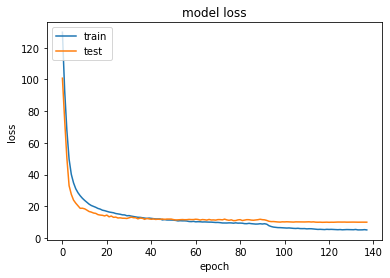

In [0]:
import matplotlib.pyplot as plt

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [0]:
total_time = datetime.datetime.now() - start_time

loss = h.history['loss']
val_loss = h.history['val_loss']

min_val_loss = min(val_loss)
min_val_loss_i = val_loss.index(min_val_loss)

time_epoch = (total_time / len(loss))
total_item = (dtgen.size['train'] + dtgen.size['valid'])

t_corpus = "\n".join([
    f"Total train images:      {dtgen.size['train']}",
    f"Total validation images: {dtgen.size['valid']}",
    f"Batch:                   {dtgen.batch_size}\n",
    f"Total time:              {total_time}",
    f"Time per epoch:          {time_epoch}",
    f"Time per item:           {time_epoch / total_item}\n",
    f"Total epochs:            {len(loss)}",
    f"Best epoch               {min_val_loss_i + 1}\n",
    f"Training loss:           {loss[min_val_loss_i]:.8f}",
    f"Validation loss:         {min_val_loss:.8f}"
])

with open(os.path.join(output_path, "train.txt"), "w") as lg:
    lg.write(t_corpus)
    print(t_corpus)

Total train images:      5369
Total validation images: 744
Batch:                   16

Total time:              2:38:01.945703
Time per epoch:          0:01:08.709751
Time per item:           0:00:00.011240

Total epochs:            138
Best epoch               118

Training loss:           5.44506931
Validation loss:         9.91868782


#***Model Predict***

Model Predict
90/90 [==============================] - 4s 48ms/step
CTC Decode
90/90 [==============================] - 34s 379ms/step



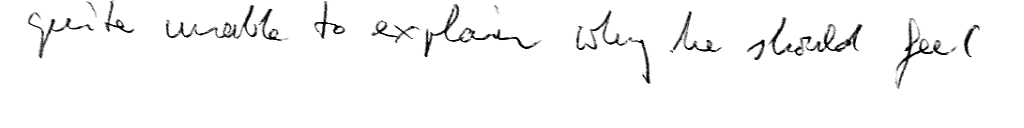

quite unable to explain why he should feel
qquite unable to explain why he should feel 




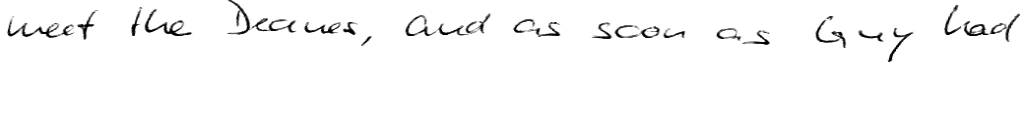

meet the Deanes , and as soon as Guy had
meet the Deanes , and as soon as Guy had 




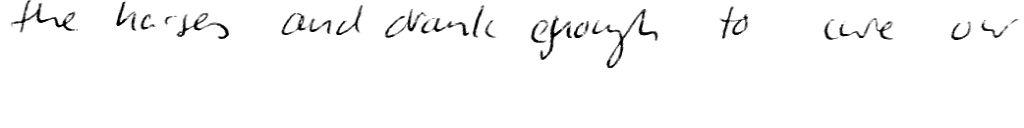

the horses and drank enough to cure our
the harges and drank egrough to cure owr 




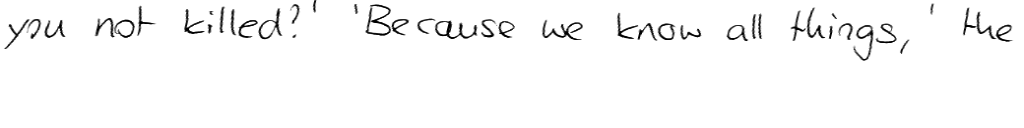

you not killed ? ' ' Because we know all things , ' the
you not killed ; ' Because we know all things , ' the 




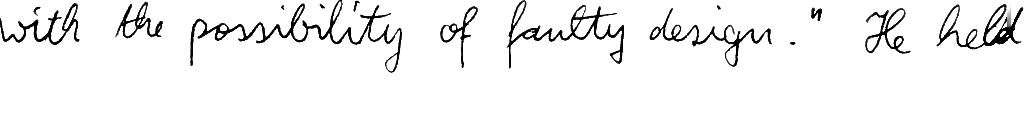

with the possibility of faulty design . " He held
with the possibility of fautty design . " He held 




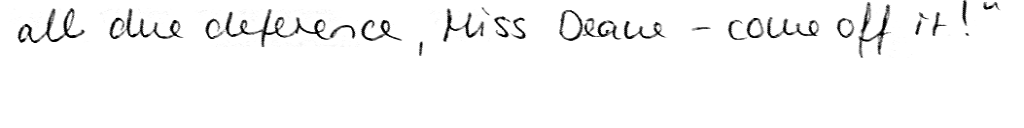

all due deference , Miss Deane - come off it !
all due deference , Miss Deane - come off it ! 




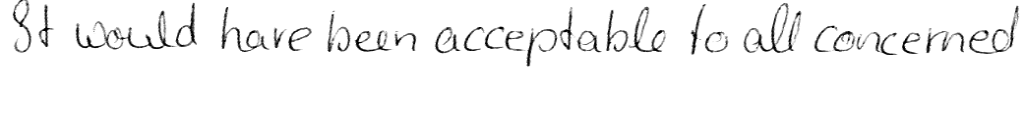

It would have been acceptable to all concerned
It would have been acceptable to all concerned 




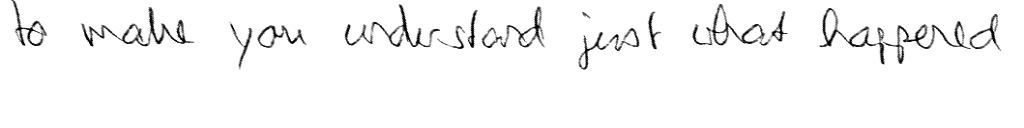

to make you understand just what happened
to maks you understard just what happened 




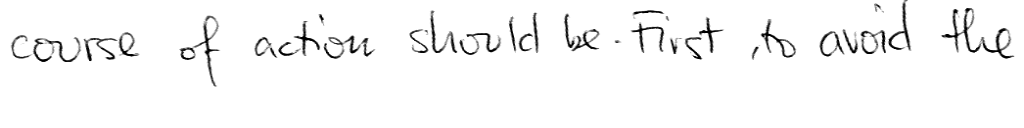

course of action should be . First , to avoid the
course of action should be . First to avoid the 




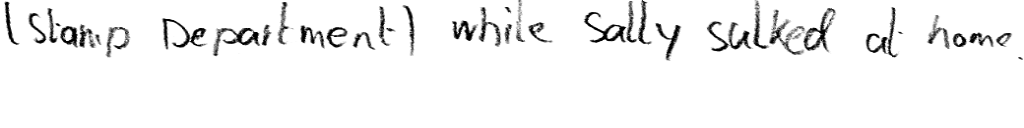

( Stamp Department ) while Sally sulked at home .
I slamp Bepartment ) while sally sulked al home . 



In [0]:

#from data import preproc as pp
from google.colab.patches import cv2_imshow

start_time = datetime.datetime.now()

# predict() function will return the predicts with the probabilities
predicts, _ = model.predict(x=dtgen.next_test_batch(),
                            steps=dtgen.steps['test'],
                            ctc_decode=True,
                            verbose=1)

# decode to string
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]

total_time = datetime.datetime.now() - start_time

# mount predict corpus file
with open(os.path.join(output_path, "predict.txt"), "w") as lg:
    for pd, gt in zip(predicts, dtgen.dataset['test']['gt']):
        lg.write(f"TE_L {gt}\nTE_P {pd}\n")
   
for i, item in enumerate(dtgen.dataset['test']['dt'][:10]):
    print("=" * 1024, "\n")
    cv2_imshow(adjust_to_see(item))
    print(dtgen.dataset['test']['gt'][i])
    print(predicts[i], "\n")

#***Model Accuracy***

In [0]:
evaluate = ocr_metrics(predicts=predicts,ground_truth=dtgen.dataset['test']['gt'],norm_accentuation=False,norm_punctuation=False)

In [0]:
 e_corpus = "\n".join([
                f"Total test images:    {dtgen.size['test']}",
                f"Total time:           {total_time}",
                f"Time per item:        {total_time / dtgen.size['test']}\n",
                f"Metrics:",
                f"Character Error Rate: {evaluate[0]:.8f}",
                f"Word Error Rate:      {evaluate[1]:.8f}",
                f"Sequence Error Rate:  {evaluate[2]:.8f}"
            ])
 with open(os.path.join(output_path, "evaluate.txt"), "w") as lg:
                  lg.write(e_corpus)
                  print(e_corpus)


Total test images:    1425
Total time:           0:00:40.284699
Time per item:        0:00:00.028270

Metrics:
Character Error Rate: 0.05671490
Word Error Rate:      0.18330952
Sequence Error Rate:  0.74877193


#***Prediction On Images***

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.

####################################

Predict:
where Mochine learning comes into action , to help

############Image##############


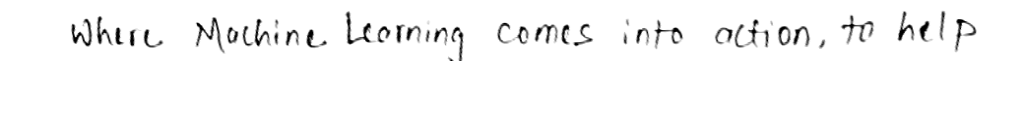

In [16]:
from google.colab.patches import cv2_imshow
image='/content/gdrive/My Drive/Colab Notebooks/MFiles/self.png';
tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length)
img = preprocess(image, input_size=input_size)
x_test = normalization([img])

model = HTRModel(architecture=arch,
 input_size=input_size,
 vocab_size=tokenizer.vocab_size,
 top_paths=10)

model.compile()
model.load_checkpoint(target=target_path)

predicts, probabilities = model.predict(x_test, ctc_decode=True)
predicts = [[tokenizer.decode(x) for x in y] for y in predicts]

print("\n####################################")
for i, (pred, prob) in enumerate(zip(predicts, probabilities)):
  print("\nPredict:")
  for (pd, pb) in zip(pred, prob):
    print(f"{pd}")
   # cv2_imshow( adjust_to_see(img))

print("\n############Image##############")
cv2_imshow( adjust_to_see(img))


####################################

Predict:
A MOVE to stop Mr . Gaitskell from

############Image##############


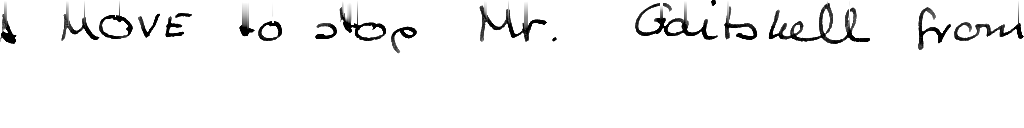

In [0]:
from google.colab.patches import cv2_imshow
image='/content/gdrive/My Drive/Colab Notebooks/MFiles/testImage.png';
tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length)
img = preprocess(image, input_size=input_size)
x_test = normalization([img])

model = HTRModel(architecture=arch,
 input_size=input_size,
 vocab_size=tokenizer.vocab_size,
 top_paths=10)

model.compile()
model.load_checkpoint(target=target_path)

predicts, probabilities = model.predict(x_test, ctc_decode=True)
predicts = [[tokenizer.decode(x) for x in y] for y in predicts]

print("\n####################################")
for i, (pred, prob) in enumerate(zip(predicts, probabilities)):
  print("\nPredict:")
  for (pd, pb) in zip(pred, prob):
    print(f"{pd}")
  
print("\n############Image##############")
cv2_imshow( adjust_to_see(img))


####################################

Predict:
clothed leaf by leaf with the disappointment

############Image##############


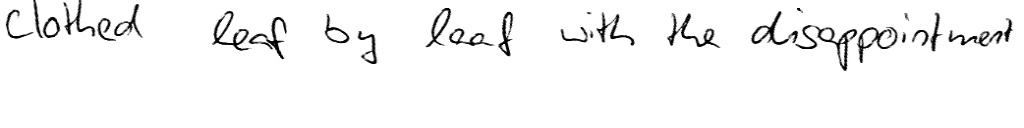

In [0]:
from google.colab.patches import cv2_imshow
image='/content/gdrive/My Drive/Colab Notebooks/MFiles/testImage1.png';
tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length)
img = preprocess(image, input_size=input_size)
x_test = normalization([img])

model = HTRModel(architecture=arch,
 input_size=input_size,
 vocab_size=tokenizer.vocab_size,
 top_paths=10)

model.compile()
model.load_checkpoint(target=target_path)

predicts, probabilities = model.predict(x_test, ctc_decode=True)
predicts = [[tokenizer.decode(x) for x in y] for y in predicts]

print("\n####################################")
for i, (pred, prob) in enumerate(zip(predicts, probabilities)):
  print("\nPredict:")
  for (pd, pb) in zip(pred, prob):
    print(f"{pd}")
print("\n############Image##############")
cv2_imshow( adjust_to_see(img))


####################################

Predict:
thank you . Great lakes

############Image##############


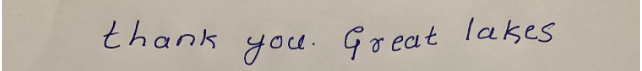

In [41]:
from google.colab.patches import cv2_imshow
image='/content/gdrive/My Drive/Colab Notebooks/MFiles/1.PNG';
tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length)
img = preprocess(image, input_size=input_size)
x_test = normalization([img])

model = HTRModel(architecture=arch,
 input_size=input_size,
 vocab_size=tokenizer.vocab_size,
 top_paths=10)

model.compile()
model.load_checkpoint(target=target_path)

predicts, probabilities = model.predict(x_test, ctc_decode=True)
predicts = [[tokenizer.decode(x) for x in y] for y in predicts]

print("\n####################################")
for i, (pred, prob) in enumerate(zip(predicts, probabilities)):
  print("\nPredict:")
  for (pd, pb) in zip(pred, prob):
    print(f"{pd}")
print("\n############Image##############")
img = cv2.imread("/content/gdrive/My Drive/Colab Notebooks/MFiles/1.PNG")
cv2_imshow(img)
#cv2_imshow( adjust_to_see(img))


####################################

Predict:
leaders have identical ideas .

############Image##############


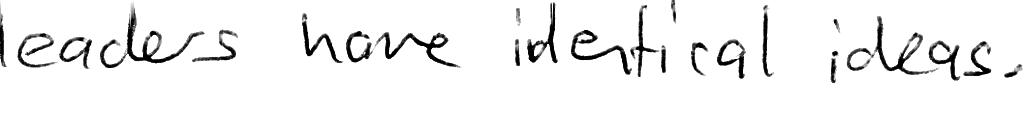

In [0]:
from IPython.display import Image

from google.colab.patches import cv2_imshow
image='/content/gdrive/My Drive/Colab Notebooks/MFiles/Leader.png';
Image(filename='/content/gdrive/My Drive/Colab Notebooks/MFiles/Leader.png') 
tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length)
img = preprocess(image, input_size=input_size)
x_test = normalization([img])

model = HTRModel(architecture=arch,
 input_size=input_size,
 vocab_size=tokenizer.vocab_size,
 top_paths=10)

model.compile()
model.load_checkpoint(target=target_path)

predicts, probabilities = model.predict(x_test, ctc_decode=True)
predicts = [[tokenizer.decode(x) for x in y] for y in predicts]

print("\n####################################")
for i, (pred, prob) in enumerate(zip(predicts, probabilities)):
  print("\nPredict:")
  for (pd, pb) in zip(pred, prob):
    print(f"{pd}")

print("\n############Image##############")
cv2_imshow( adjust_to_see(img))


####################################

Predict:
life is gradieat descent

############Image##############


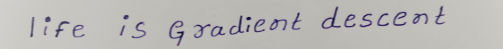

In [76]:
from google.colab.patches import cv2_imshow
image='/content/gdrive/My Drive/Colab Notebooks/MFiles/0.PNG';
tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length)
img = preprocess(image, input_size=input_size)
x_test = normalization([img])

model = HTRModel(architecture=arch,
 input_size=input_size,
 vocab_size=tokenizer.vocab_size,
 top_paths=10)

model.compile()
model.load_checkpoint(target=target_path)

predicts, probabilities = model.predict(x_test, ctc_decode=True)
predicts = [[tokenizer.decode(x) for x in y] for y in predicts]

print("\n####################################")
for i, (pred, prob) in enumerate(zip(predicts, probabilities)):
  print("\nPredict:")
  for (pd, pb) in zip(pred, prob):
    print(f"{pd}")
print("\n############Image##############")
img = cv2.imread("/content/gdrive/My Drive/Colab Notebooks/MFiles/0.PNG")
cv2_imshow(img)
#cv2_imshow( adjust_to_see(img))


####################################

Predict:
stay safe , stay kind , stay alive a

############Image##############


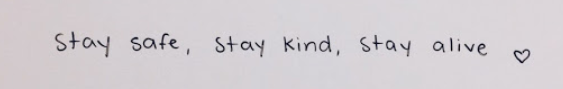

In [80]:
from google.colab.patches import cv2_imshow
#stayhome
image='/content/gdrive/My Drive/Colab Notebooks/MFiles/stayhome.PNG';
tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length)
img = preprocess(image, input_size=input_size)
x_test = normalization([img])

model = HTRModel(architecture=arch,
 input_size=input_size,
 vocab_size=tokenizer.vocab_size,
 top_paths=10)

model.compile()
model.load_checkpoint(target=target_path)

predicts, probabilities = model.predict(x_test, ctc_decode=True)
predicts = [[tokenizer.decode(x) for x in y] for y in predicts]

print("\n####################################")
for i, (pred, prob) in enumerate(zip(predicts, probabilities)):
  print("\nPredict:")
  for (pd, pb) in zip(pred, prob):
    print(f"{pd}")
print("\n############Image##############")
img = cv2.imread("/content/gdrive/My Drive/Colab Notebooks/MFiles/stayhome.PNG")
cv2_imshow(img)
#cv2_imshow( adjust_to_see(img))

#***GingerIt Lanuguage correction can be used post prediction***




In [0]:
#Correct  spelling mistakes from prediction

In [56]:
pip install gingerit

In [0]:
def listToString(s):  
    str1 = " " 
    return (str1.join(s))

In [77]:
from gingerit.gingerit import GingerIt
#text = pd
text ='Same empty strects as he had the might befose'
text ="life is gradieat descent"
parser = GingerIt()
parser.parse(text)['result']

'Life is gradient descent'

#***Predict paragraph through Line segmentation technique***

In [0]:
def createKernel(kernelSize, sigma, theta):
	"""create anisotropic filter kernel according to given parameters"""
	assert kernelSize % 2 # must be odd size
	halfSize = kernelSize // 2
	
	kernel = np.zeros([kernelSize, kernelSize])
	sigmaX = sigma
	sigmaY = sigma * theta
	
	for i in range(kernelSize):
		for j in range(kernelSize):
			x = i - halfSize
			y = j - halfSize
			
			expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
			xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
			yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)
			
			kernel[i, j] = (xTerm + yTerm) * expTerm

	kernel = kernel / np.sum(kernel)
	return kernel

def lineSegmentation(img, kernelSize=25, sigma=11, theta=7):
    """Scale space technique for lines segmentation proposed by R. Manmatha:
	http://ciir.cs.umass.edu/pubfiles/mm-27.pdf
    Args:
		img: image of the text to be segmented on lines.
        kernelSize: size of filter kernel, must be an odd integer.
		sigma: standard deviation of Gaussian function used for filter kernel.
		theta: approximated width/height ratio of words, filter function is distorted by this factor.
		minArea: ignore word candidates smaller than specified area.
	Returns:
		List of lines (segmented input img)
	"""

    img_tmp = np.transpose(prepareTextImg(img))# image to be segmented (un-normalized)
    img_tmp_norm = normalize(img_tmp)
    k = createKernel(kernelSize, sigma, theta)
    imgFiltered = cv2.filter2D(img_tmp_norm, -1, k, borderType=cv2.BORDER_REPLICATE)
    img_tmp1 = normalize(imgFiltered)
    # Make summ elements in columns to get function of pixels value for each column
    summ_pix = np.sum(img_tmp1, axis = 0)
    smoothed = smooth(summ_pix, 35)
    mins = np.array(argrelmin(smoothed, order=2))
    found_lines = transpose_lines(crop_text_to_lines(img_tmp, mins[0]))
    return found_lines

def prepareTextImg(img):
    """ Convert given text image to grayscale image (if needed) and return it. """
    assert img.ndim in (2, 3)
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return (img)

def normalize(img):
    """ Normalize input image:
    img = (img[][]-mean)/ stddev
    using function: cv2.meanStdDev(src[, mean[, stddev[, mask]]]), returns: mean, stddev
    where: mean & stddev - numpy.ndarray[][] """
    (m, s) = cv2.meanStdDev(img)
    m = m[0][0]
    s = s[0][0]
    img = img - m
    img = img / s if s>0 else img
    return img

def smooth(x, window_len=11, window='hanning'):
    """ Image smoothing is achieved by convolving the image with a low-pass filter kernel.
    Such low pass filters as: ['flat', 'hanning', 'hamming', 'bartlett', 'blackman'] can be used
    It is useful for removing noise. It actually removes high frequency content
    (e.g: noise, edges) from the image resulting in edges being blurred when this is filter is applied."""
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]

    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y


def crop_text_to_lines(text, blanks):
    """ Splits the image with text into lines, according to the markup obtained from the created algorithm.
     Very first"""
    x1 = 0
    y = 0
    lines = []
    for i, blank in enumerate(blanks):
        x2 = blank
        line = text[:,  x1:x2]
        lines.append(line)
        x1 = blank
    print("Lines found: {0}".format(len(lines)))
    return lines


def transpose_lines(lines):
    res = []
    for l in lines:
        line = np.transpose(l)
        res.append(line)
    return res

def save_tmp_data(data, path, num, dtype):
    """ Save found lines in texts
        data - array/ list of data to save
        path - dir, where to save
        num - number of text/line which words were segmented from
        dtype - type of data to save: words or lines """
    # write output to 'out/inputFileName' directory
    if not os.path.exists('%s' % path):
        os.mkdir('%s' % path)

    if dtype not in ['word', 'line']:
        raise ValueError("dtype should be in 'word' or 'line'")

    if dtype == 'word':
        # Iterate over all segmented words
        print('Segmented into %d words' % len(data))
        for (j, w) in enumerate(data):
            for (k, n) in enumerate(w):
                (wordBox, wordImg) = n
                (x, y, w, h) = wordBox  # To draw bounding box in summary image (if needed)
                fn = '%s/t%d_w%d_%d.png' % (path, num, j, k)
                cv2.imwrite(fn, wordImg)  # save word

    elif dtype == 'line':
        # iterate over all segmented lines
        print('Segmented into %d lines' % len(data))
        for (j, w) in enumerate(data):
            fn = '%s/%d.png' % (path, j)
            cv2.imwrite(fn, w)  # save line


**Convert Paragraph to** **lines**

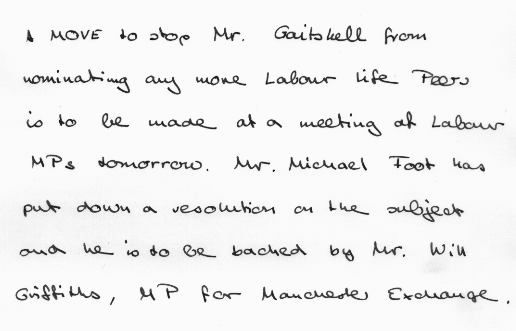

Lines found: 7
Segmented into 7 lines


In [89]:
from google.colab.patches import cv2_imshow
os.chdir('/content/gdrive/My Drive/Lines_converted')
os.system("rm -rf "+"text0_lines")
#Provide the folder path where image having paragraph is saved
fnTexts ='/content/gdrive/My Drive/Image_to_lines/'
imgFiles = os.listdir(fnTexts)
#Provide the folder path where image segmented lines has to be saved
fpath='/content/gdrive/My Drive/Lines_converted'

for (i, f) in enumerate(imgFiles):
  img = cv2.imread('%s%s' % (fnTexts, f))
  cv2_imshow(img)
  tmp_lines =lineSegmentation(img)
  fpath = ("%s/text%d_lines/" % (fpath, i))
  save_tmp_data(tmp_lines, fpath, i, dtype='line')

***Predict All the images and append to an list ***

In [90]:
Predict_all =[]
tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length)
fnTexts='/content/gdrive/My Drive/Lines_converted/text0_lines/';
imgFiles = os.listdir(fnTexts)
imgFiles.sort()
for (i, f) in enumerate(imgFiles):
  image = fnTexts+f
  img = preprocess(image, input_size=input_size)
  x_test = normalization([img])
  model = HTRModel(architecture=arch,
  input_size=input_size,
  vocab_size=tokenizer.vocab_size,
  top_paths=10)

  model.compile()
  model.load_checkpoint(target=target_path)

  predicts, probabilities = model.predict(x_test, ctc_decode=True)
  predicts = [[tokenizer.decode(x) for x in y] for y in predicts]
  Predict_all.extend(predicts) 
documents = [sub_list[0] for sub_list in Predict_all]
print("\n#################Predict###################\n")
print ('\n '.join(map(str, documents)))
print("\n###########################################")


#################Predict###################

I hOVE to stop Mr . Gaitskell from
 nominating any more Labour life Peers
 is to be made at a meeting of Labour
 MPs 1omorrow . Mr . Michael Foot has
 put down a resoltion on the subject
 and he is to be backed by Mr . Will
 Griffiths , MP for Manchester Exchange .

###########################################


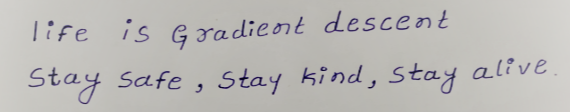

Lines found: 2
Segmented into 2 lines


In [82]:
from google.colab.patches import cv2_imshow
os.chdir('/content/gdrive/My Drive/Lines_converted')
os.system("rm -rf "+"text0_lines")
#Provide the folder path where image having paragraph is saved
fnTexts ='/content/gdrive/My Drive/Image_to_lines/'
imgFiles = os.listdir(fnTexts)
#Provide the folder path where image segmented lines has to be saved
fpath='/content/gdrive/My Drive/Lines_converted'

for (i, f) in enumerate(imgFiles):
  img = cv2.imread('%s%s' % (fnTexts, f))
  cv2_imshow(img)
  tmp_lines =lineSegmentation(img)
  fpath = ("%s/text%d_lines/" % (fpath, i))
  save_tmp_data(tmp_lines, fpath, i, dtype='line')

In [88]:
Predict_all =[]
tokenizer = Tokenizer(chars=charset_base, max_text_length=max_text_length)
fnTexts='/content/gdrive/My Drive/Lines_converted/text0_lines/';
imgFiles = os.listdir(fnTexts)
imgFiles.sort()
for (i, f) in enumerate(imgFiles):
  image = fnTexts+f
  img = preprocess(image, input_size=input_size)
  x_test = normalization([img])
  model = HTRModel(architecture=arch,
  input_size=input_size,
  vocab_size=tokenizer.vocab_size,
  top_paths=10)

  model.compile()
  model.load_checkpoint(target=target_path)

  predicts, probabilities = model.predict(x_test, ctc_decode=True)
  predicts = [[tokenizer.decode(x) for x in y] for y in predicts]
  Predict_all.extend(predicts) 
documents = [sub_list[0] for sub_list in Predict_all]
print("\n#################Predict###################\n")
print ('\n '.join(map(str, documents)))
print("\n###########################################")



#################Predict###################

life is aradient descent
 stay safe , stay kind , stay allive .

###########################################


#***Data Transformation***

***Below Code will be executed only once for creating h5py file format for IAM Dataset. ***

In [0]:
source = "iam"
arch = "flor"
raw_path='/content/gdrive/My Drive/Colab Notebooks/Data/iam/'
source_path = os.path.join("..", "data", f"{source}.hdf5")
output_path = os.path.join("..", "output", source, arch)
target_path = os.path.join(output_path, "checkpoint_weights.hdf5")
assert os.path.exists(raw_path)
print(f"The {source} dataset will be transformed...")
ds = Dataset(source=raw_path, name=source)
ds.read_partitions()

print("Partitions will be preprocessed...")
ds.preprocess_partitions(input_size=input_size)

print("Partitions will be saved...")
os.makedirs(os.path.dirname(source_path), exist_ok=True)
for i in ds.partitions:
            with h5py.File(source_path, "a") as hf:
                hf.create_dataset(f"{i}/dt", data=ds.dataset[i]['dt'], compression="gzip", compression_opts=9)
                hf.create_dataset(f"{i}/gt", data=ds.dataset[i]['gt'], compression="gzip", compression_opts=9)
                print(f"[OK] {i} partition.")

print(f"Transformation finished.")